## The lending club

We'll be working with financial lending data from Lending Club. Lending Club is a marketplace for personal loans that matches borrowers who are seeking a loan with investors looking to lend money and make a return. You can read more about their marketplace __[here](https://www.lendingclub.com/public/how-peer-lending-works.action)__.

Each borrower fills out a comprehensive application, providing their past financial history, the reason for the loan, and more. Lending Club evaluates each borrower's credit score using past historical data (and their own data science process!) and assign an interest rate to the borrower. The interest rate is the percent in addition to the requested loan amount the borrower has to pay back.

A higher interest rate means that the borrower is riskier and more unlikely to pay back the loan while a lower interest rate means that the borrower has a good credit history is more likely to pay back the loan. The interest rates range from 5.32% all the way to 30.99% and each borrower is given a grade according to the interest rate they were assigned. If the borrower accepts the interest rate, then the loan is listed on the Lending Club marketplace.

Most investors use a portfolio strategy to invest small amounts in many loans, with healthy mixes of low, medium, and interest loans. In this course, we'll focus on the mindset of a conservative investor who only wants to invest in the loans that have a good chance of being paid off on time. To do that, we'll need to first understand the features in the dataset and then experiment with building machine learning models that reliably predict if a loan will be paid off or not.

Lending Club releases data for all of the approved and declined loan applications periodically __[on their website](https://www.lendingclub.com/info/download-data.action)__. You can select a few different year ranges to download the datasets (in CSV format) for both approved and declined loans.

You'll also find a data dictionary (in XLS format) which contains information on the different column names towards the bottom of the page. We recommend downloading the data dictionary to so you can refer to it whenever you want to learn more about what a column represents in the datasets. Here's a link to the data dictionary file hosted on __[Google Drive](https://docs.google.com/spreadsheets/d/191B2yJ4H1ZPXq0_ByhUgWMFZOYem5jFz0Y3by_7YBY4/edit#gid=2081333097)__.

Before diving into the datasets themselves, let's get familiar with the data dictionary. The LoanStats sheet describes the approved loans datasets and the RejectStats describes the rejected loans datasets. Since rejected applications don't appear on the Lending Club marketplace and aren't available for investment, we'll be focusing on data on approved loans only.

The approved loans datasets contain information on current loans, completed loans, and defaulted loans.


## The problem statement
Can we build a machine learning model that can accurately predict if a borrower will pay off their loan on time or not?

In [1]:
#importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#reading the dataset
loans_2007 = pd.read_csv('loans_2007.csv')

In [3]:
loans_2007.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,171.62,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,119.66,Sep-2013,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,649.91,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
3,1076863,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,357.48,Apr-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
4,1075358,1311748.0,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,67.79,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0


The Dataframe contains many columns and can be cumbersome to try to explore all at once. Let's break up the columns into 3 groups of 18 columns and use the data dictionary to become familiar with what each column represents. As we understand each feature, we want to pay attention to any features that:

1. leak information from the future (after the loan has already been funded)
2. don't affect a borrower's ability to pay back a loan (e.g. a randomly generated ID value by Lending Club)
3. formatted poorly and need to be cleaned up
4. require more data or a lot of processing to turn into a useful feature
5. contain redundant information

### EDA

In [4]:
columns = list(loans_2007.columns)

In [5]:
first_group = columns[:18]
second_group = columns[18:36]
third_group = columns[36:52]

In [6]:
first_group

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan']

To make this process easier, we created a table that contains the name and description from the data dictionary for the first 18 rows.

<img src='first_grp.JPG'>

After analyzing each column, we can conclude that the following features need to be **removed**:

1. **id**: don't affect the borower's ability to pay back a loan
2. **member_id**: don't affect the borower's ability to pay back a loan
3. **funded_amnt**: leak information from the future (after the loan has already been funded)
4. **funded_amnt_inv**: leak information from the future (after the loan has already been funded)
5. **grade**: redundant information (directly related to int rate)
6. **sub_grade**: redundant information (directly related to int rate)
7. **emp_title**: require more data or a lot of processing to turn into a useful feature
8. **issue_d**: leak information from the future (after the loan has already been funded)

In [7]:
#removing the first group redundant features
loans_2007.drop(columns=['id','member_id','funded_amnt','funded_amnt_inv','grade','sub_grade','emp_title','issue_d'], axis=1, inplace=True)

In [8]:
second_group

['purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv']

In [9]:
third_group

['total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'policy_code',
 'application_type',
 'acc_now_delinq',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'pub_rec_bankruptcies',
 'tax_liens']

Continuing the elimination process for second and third group

<img src='second_grp.JPG'>

From the second group we get rid of the following features:

1. **zip_code**: redundant with the addr_state column since only the first 3 digits of the 5 digit zip code are visible (which only can be used to identify the state the borrower lives in)
2. **out_prncp**: leaks data from the future, (after the loan already started to be paid off)
3. **out_prncp_inv**: also leaks data from the future, (after the loan already started to be paid off)
4. **total_pymnt**: also leaks data from the future, (after the loan already started to be paid off)
5. **total_pymnt_inv**: also leaks data from the future, (after the loan already started to be paid off)
6. **total_rec_prncp**: also leaks data from the future, (after the loan already started to be paid off)

<img src='second_grp.JPG'>

In the last group of columns, we need to drop the following columns:

1. **total_rec_int**: leaks data from the future, (after the loan already started to be paid off),
2. **total_rec_late_fee**: also leaks data from the future, (after the loan already started to be paid off),
3. **recoveries**: also leaks data from the future, (after the loan already started to be paid off),
4. **collection_recovery_fee**: also leaks data from the future, (after the loan already started to be paid off),
5. **last_pymnt_d**: also leaks data from the future, (after the loan already started to be paid off),
6. **last_pymnt_amnt**: also leaks data from the future, (after the loan already started to be paid off).

In [10]:
loans_2007.drop(columns=['zip_code','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d','last_pymnt_amnt'], inplace=True)

In [11]:
loans_2007.shape

(42538, 32)

### Feature Engineering

We'll use the 'loan_status' feature as our target column

In [12]:
loans_2007['loan_status'].value_counts()

Fully Paid                                             33136
Charged Off                                             5634
Does not meet the credit policy. Status:Fully Paid      1988
Current                                                  961
Does not meet the credit policy. Status:Charged Off      761
Late (31-120 days)                                        24
In Grace Period                                           20
Late (16-30 days)                                          8
Default                                                    3
Name: loan_status, dtype: int64

From the investor's perspective, we're interested in trying to predict which loans will be paid off on time and which ones won't be. Only the Fully Paid and Charged Off values describe the final outcome of the loan. The other values describe loans that are still on going and where the jury is still out on if the borrower will pay back the loan on time or not. While the Default status resembles the Charged Off status, in Lending Club's eyes, loans that are charged off have essentially no chance of being repaid while default ones have a small chance.

Since we're interested in being able to predict which of these 2 values a loan will fall under, we can treat the problem as a binary classification one. Let's remove all the loans that don't contain either Fully Paid and Charged Off as the loan's status and then transform the Fully Paid values to 1 for the positive case and the Charged Off values to 0 for the negative case

In [13]:
loans_2007 = loans_2007[(loans_2007['loan_status']=='Fully Paid') | (loans_2007['loan_status']=='Charged Off')]

In [14]:
loans_2007['loan_status'] = loans_2007['loan_status'].map({'Fully Paid':1, 'Charged Off':0})

In [15]:
pd.options.display.max_columns = 50
loans_2007.head()

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,title,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,5000.0,36 months,10.65%,162.87,10+ years,RENT,24000.0,Verified,1,n,credit_card,Computer,AZ,27.65,0.0,Jan-1985,1.0,3.0,0.0,13648.0,83.7%,9.0,f,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
1,2500.0,60 months,15.27%,59.83,< 1 year,RENT,30000.0,Source Verified,0,n,car,bike,GA,1.00,0.0,Apr-1999,5.0,3.0,0.0,1687.0,9.4%,4.0,f,Sep-2013,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
2,2400.0,36 months,15.96%,84.33,10+ years,RENT,12252.0,Not Verified,1,n,small_business,real estate business,IL,8.72,0.0,Nov-2001,2.0,2.0,0.0,2956.0,98.5%,10.0,f,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
3,10000.0,36 months,13.49%,339.31,10+ years,RENT,49200.0,Source Verified,1,n,other,personel,CA,20.00,0.0,Feb-1996,1.0,10.0,0.0,5598.0,21%,37.0,f,Apr-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
5,5000.0,36 months,7.90%,156.46,3 years,RENT,36000.0,Source Verified,1,n,wedding,My wedding loan I promise to pay back,AZ,11.20,0.0,Nov-2004,3.0,9.0,0.0,7963.0,28.3%,12.0,f,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0


In [16]:
loans_2007['emp_length'].value_counts()

10+ years    8547
< 1 year     4527
2 years      4308
3 years      4026
4 years      3362
5 years      3209
1 year       3183
6 years      2181
7 years      1718
8 years      1444
9 years      1229
Name: emp_length, dtype: int64

In [17]:
loans_2007.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38770 entries, 0 to 39785
Data columns (total 32 columns):
loan_amnt                     38770 non-null float64
term                          38770 non-null object
int_rate                      38770 non-null object
installment                   38770 non-null float64
emp_length                    37734 non-null object
home_ownership                38770 non-null object
annual_inc                    38770 non-null float64
verification_status           38770 non-null object
loan_status                   38770 non-null int64
pymnt_plan                    38770 non-null object
purpose                       38770 non-null object
title                         38759 non-null object
addr_state                    38770 non-null object
dti                           38770 non-null float64
delinq_2yrs                   38770 non-null float64
earliest_cr_line              38770 non-null object
inq_last_6mths                38770 non-null float64
op

In [18]:
loans_2007.isnull().sum()

loan_amnt                        0
term                             0
int_rate                         0
installment                      0
emp_length                    1036
home_ownership                   0
annual_inc                       0
verification_status              0
loan_status                      0
pymnt_plan                       0
purpose                          0
title                           11
addr_state                       0
dti                              0
delinq_2yrs                      0
earliest_cr_line                 0
inq_last_6mths                   0
open_acc                         0
pub_rec                          0
revol_bal                        0
revol_util                      50
total_acc                        0
initial_list_status              0
last_credit_pull_d               2
collections_12_mths_ex_med      56
policy_code                      0
application_type                 0
acc_now_delinq                   0
chargeoff_within_12_

In [19]:
loans_2007.drop('pub_rec_bankruptcies', axis=1, inplace=True)
loans_2007.dropna()

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,title,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,tax_liens
0,5000.0,36 months,10.65%,162.87,10+ years,RENT,24000.00,Verified,1,n,credit_card,Computer,AZ,27.65,0.0,Jan-1985,1.0,3.0,0.0,13648.0,83.7%,9.0,f,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0
1,2500.0,60 months,15.27%,59.83,< 1 year,RENT,30000.00,Source Verified,0,n,car,bike,GA,1.00,0.0,Apr-1999,5.0,3.0,0.0,1687.0,9.4%,4.0,f,Sep-2013,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0
2,2400.0,36 months,15.96%,84.33,10+ years,RENT,12252.00,Not Verified,1,n,small_business,real estate business,IL,8.72,0.0,Nov-2001,2.0,2.0,0.0,2956.0,98.5%,10.0,f,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0
3,10000.0,36 months,13.49%,339.31,10+ years,RENT,49200.00,Source Verified,1,n,other,personel,CA,20.00,0.0,Feb-1996,1.0,10.0,0.0,5598.0,21%,37.0,f,Apr-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0
5,5000.0,36 months,7.90%,156.46,3 years,RENT,36000.00,Source Verified,1,n,wedding,My wedding loan I promise to pay back,AZ,11.20,0.0,Nov-2004,3.0,9.0,0.0,7963.0,28.3%,12.0,f,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0
6,7000.0,60 months,15.96%,170.08,8 years,RENT,47004.00,Not Verified,1,n,debt_consolidation,Loan,NC,23.51,0.0,Jul-2005,1.0,7.0,0.0,17726.0,85.6%,11.0,f,May-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0
7,3000.0,36 months,18.64%,109.43,9 years,RENT,48000.00,Source Verified,1,n,car,Car Downpayment,CA,5.35,0.0,Jan-2007,2.0,4.0,0.0,8221.0,87.5%,4.0,f,Dec-2014,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0
8,5600.0,60 months,21.28%,152.39,4 years,OWN,40000.00,Source Verified,0,n,small_business,Expand Business & Buy Debt Portfolio,CA,5.55,0.0,Apr-2004,2.0,11.0,0.0,5210.0,32.6%,13.0,f,Aug-2012,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0
9,5375.0,60 months,12.69%,121.45,< 1 year,RENT,15000.00,Verified,0,n,other,Building my credit history.,TX,18.08,0.0,Sep-2004,0.0,2.0,0.0,9279.0,36.5%,3.0,f,Mar-2013,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0
10,6500.0,60 months,14.65%,153.45,5 years,OWN,72000.00,Not Verified,1,n,debt_consolidation,High intrest Consolidation,AZ,16.12,0.0,Jan-1998,2.0,14.0,0.0,4032.0,20.6%,23.0,f,Dec-2015,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0


In [20]:
loans_2007 = loans_2007.dropna()

In [21]:
#Converting string to numeric columns

loans_2007['term'] = loans_2007['term'].str.replace(' months', '').astype(int)
loans_2007['int_rate'] = loans_2007['int_rate'].str.replace('%', '').astype(float)

#for the 'emp_length' column, after removing the sub-string 'years', we'll replace the values '< 1' and '10+' to 1 and 10 respectively
#post that we'll convert the dtype to float

#loans_2007['emp_length'] = loans_2007['emp_length'].str.replace(' years', '').str.replace(' year','').map({'< 1':1, '10+':10})
#loans_2007['emp_length'] = loans_2007['emp_length'].astype(int)
loans_2007['revol_util'] = loans_2007['revol_util'].str.replace('%', '').astype(float)


In [22]:
loans_2007.head()

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,title,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,tax_liens
0,5000.0,36,10.65,162.87,10+ years,RENT,24000.0,Verified,1,n,credit_card,Computer,AZ,27.65,0.0,Jan-1985,1.0,3.0,0.0,13648.0,83.7,9.0,f,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0
1,2500.0,60,15.27,59.83,< 1 year,RENT,30000.0,Source Verified,0,n,car,bike,GA,1.00,0.0,Apr-1999,5.0,3.0,0.0,1687.0,9.4,4.0,f,Sep-2013,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0
2,2400.0,36,15.96,84.33,10+ years,RENT,12252.0,Not Verified,1,n,small_business,real estate business,IL,8.72,0.0,Nov-2001,2.0,2.0,0.0,2956.0,98.5,10.0,f,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0
3,10000.0,36,13.49,339.31,10+ years,RENT,49200.0,Source Verified,1,n,other,personel,CA,20.00,0.0,Feb-1996,1.0,10.0,0.0,5598.0,21.0,37.0,f,Apr-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0
5,5000.0,36,7.90,156.46,3 years,RENT,36000.0,Source Verified,1,n,wedding,My wedding loan I promise to pay back,AZ,11.20,0.0,Nov-2004,3.0,9.0,0.0,7963.0,28.3,12.0,f,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0


There are two columns 
1. earliest_cr_line: The month the borrower's earliest reported credit line was opened,
2. last_credit_pull_d: The most recent month Lending Club pulled credit for this loan,

which basically represent dates but are stored as object types

Also, to use these features in a model we would need to do some good amount of feature engineering.

Let's first convert them to date time dtype and then make a separate column showing the number of months passed till date

In [23]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
months_n = ['01','02','03','04','05','06','07','08','09','10','11','12']
for i, m in enumerate(months):
    loans_2007['earliest_cr_line'] = loans_2007['earliest_cr_line'].str.replace(m,months_n[i])

In [24]:
import datetime
loans_2007['earliest_cr_line'] = pd.to_datetime(loans_2007['earliest_cr_line'], format='%m-%Y')

In [25]:
from datetime import datetime
d = datetime.strptime('1-2018', '%m-%Y')

In [26]:
s = d-loans_2007['earliest_cr_line']
loans_2007['days_from_earl_cr'] = s

In [27]:
loans_2007['days_from_earl_cr'] = loans_2007['days_from_earl_cr'].astype(str).str.replace(' days 00:00:00.000000000','').astype(int)

In [28]:
for i, m in enumerate(months):
    loans_2007['last_credit_pull_d'] = loans_2007['last_credit_pull_d'].str.replace(m,months_n[i])
    
loans_2007['last_credit_pull_d'] = pd.to_datetime(loans_2007['last_credit_pull_d'], format='%m-%Y')
a = d-loans_2007['last_credit_pull_d']
loans_2007['last_credit_pull_d'] = a
loans_2007['last_credit_pull_d'] = loans_2007['last_credit_pull_d'].astype(str).str.replace(' days 00:00:00.000000000','').astype(int)

In [31]:
loans_2007.drop(columns='earliest_cr_line', axis=1, inplace=True)

In [34]:
#mapping 'emp_length' column
mapping_dict = {
    "emp_length": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
        "n/a": 0
    }
}

loans_2007 = loans_2007.replace(mapping_dict)

In [43]:
loans_2007.describe()

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_credit_pull_d,collections_12_mths_ex_med,policy_code,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,tax_liens,days_from_earl_cr
count,37619.000000,37619.000000,37619.000000,37619.000000,37619.000000,3.761900e+04,37619.000000,37619.000000,37619.000000,37619.000000,37619.000000,37619.000000,37619.000000,37619.000000,37619.000000,37619.000000,37619.0,37619.0,37619.0,37619.0,37619.0,37619.0,37619.000000
mean,11158.043808,42.023127,11.977739,325.243709,4.950052,6.943578e+04,0.856907,13.299708,0.147027,0.872272,9.307238,0.053749,13388.723491,48.896843,22.110024,1208.269252,0.0,1.0,0.0,0.0,0.0,0.0,7589.822616
std,7368.990002,10.405761,3.689526,208.895161,3.557818,6.462233e+04,0.350172,6.659987,0.493237,1.071172,4.394942,0.234653,15889.914009,28.332708,11.407353,642.707159,0.0,0.0,0.0,0.0,0.0,0.0,2424.508746
min,500.000000,36.000000,5.420000,15.690000,0.000000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,579.000000,0.0,1.0,0.0,0.0,0.0,0.0,3348.000000
25%,5500.000000,36.000000,9.040000,167.730000,2.000000,4.100000e+04,1.000000,8.180000,0.000000,0.000000,6.000000,0.000000,3714.000000,25.500000,14.000000,579.000000,0.0,1.0,0.0,0.0,0.0,0.0,5966.000000
50%,10000.000000,36.000000,11.830000,280.970000,4.000000,6.000000e+04,1.000000,13.390000,0.000000,1.000000,9.000000,0.000000,8877.000000,49.300000,20.000000,1037.000000,0.0,1.0,0.0,0.0,0.0,0.0,7154.000000
75%,15000.000000,60.000000,14.460000,430.300000,9.000000,8.300000e+04,1.000000,18.560000,0.000000,1.000000,12.000000,0.000000,17043.000000,72.400000,29.000000,1706.000000,0.0,1.0,0.0,0.0,0.0,0.0,8766.000000
max,35000.000000,60.000000,24.590000,1305.190000,10.000000,6.000000e+06,1.000000,29.990000,11.000000,8.000000,44.000000,4.000000,149588.000000,99.900000,90.000000,3806.000000,0.0,1.0,0.0,0.0,0.0,0.0,26298.000000


In [44]:
x = ['collections_12_mths_ex_med','policy_code','acc_now_delinq','chargeoff_within_12_mths','delinq_amnt','tax_liens']
for col in x:
    print(len(loans_2007[col].unique()))

1
1
1
1
1
1


In [45]:
loans_2007.drop(x, axis=1, inplace=True)

In [49]:
#let's look at the unique value counts for the purpose and title columns to understand which column we want to keep.

print(loans_2007["purpose"].value_counts())
print(loans_2007["title"].value_counts())

debt_consolidation    17738
credit_card            4898
other                  3705
home_improvement       2799
major_purchase         2083
small_business         1714
car                    1458
wedding                 915
medical                 655
moving                  550
house                   355
vacation                346
educational             309
renewable_energy         94
Name: purpose, dtype: int64
Debt Consolidation                          2068
Debt Consolidation Loan                     1599
Personal Loan                                624
Consolidation                                487
debt consolidation                           466
Credit Card Consolidation                    345
Home Improvement                             335
Debt consolidation                           314
Small Business Loan                          298
Credit Card Loan                             294
Personal                                     290
Consolidation Loan                       

It seems like the purpose and title columns do contain overlapping information but we'll keep the purpose column since it contains a few discrete values. In addition, the title column has data quality issues since many of the values are repeated with slight modifications (e.g. Debt Consolidation and Debt Consolidation Loan and debt consolidation).

Lastly, the addr_state column contains many discrete values and we'd need to add 49 dummy variable columns to use it for classification. This would make our Dataframe much larger and could slow down how quickly the code runs. Let's remove this column from consideration.

In [50]:
loans_2007.drop(['title', 'addr_state'], axis=1, inplace=True)

In [53]:
print(loans_2007['initial_list_status'].value_counts())
print(loans_2007['application_type'].value_counts())

f    37619
Name: initial_list_status, dtype: int64
INDIVIDUAL    37619
Name: application_type, dtype: int64


In [54]:
loans_2007.drop(['initial_list_status', 'application_type'], axis=1, inplace=True)

In [58]:
loans_2007.drop('pymnt_plan', axis=1, inplace=True)

In [67]:
loans_2007.head(10)

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_credit_pull_d,days_from_earl_cr
0,5000.0,36,10.65,162.87,10,RENT,24000.0,Verified,1,credit_card,27.65,0.0,1.0,3.0,0.0,13648.0,83.7,9.0,579,12053
1,2500.0,60,15.27,59.83,0,RENT,30000.0,Source Verified,0,car,1.00,0.0,5.0,3.0,0.0,1687.0,9.4,4.0,1583,6850
2,2400.0,36,15.96,84.33,10,RENT,12252.0,Not Verified,1,small_business,8.72,0.0,2.0,2.0,0.0,2956.0,98.5,10.0,579,5905
3,10000.0,36,13.49,339.31,10,RENT,49200.0,Source Verified,1,other,20.00,0.0,1.0,10.0,0.0,5598.0,21.0,37.0,640,8005
5,5000.0,36,7.90,156.46,3,RENT,36000.0,Source Verified,1,wedding,11.20,0.0,3.0,9.0,0.0,7963.0,28.3,12.0,731,4809
6,7000.0,60,15.96,170.08,8,RENT,47004.0,Not Verified,1,debt_consolidation,23.51,0.0,1.0,7.0,0.0,17726.0,85.6,11.0,610,4567
7,3000.0,36,18.64,109.43,9,RENT,48000.0,Source Verified,1,car,5.35,0.0,2.0,4.0,0.0,8221.0,87.5,4.0,1127,4018
8,5600.0,60,21.28,152.39,4,OWN,40000.0,Source Verified,0,small_business,5.55,0.0,2.0,11.0,0.0,5210.0,32.6,13.0,1979,5023
9,5375.0,60,12.69,121.45,0,RENT,15000.0,Verified,0,other,18.08,0.0,0.0,2.0,0.0,9279.0,36.5,3.0,1767,4870
10,6500.0,60,14.65,153.45,5,OWN,72000.0,Not Verified,1,debt_consolidation,16.12,0.0,2.0,14.0,0.0,4032.0,20.6,23.0,762,7305


### Visual analysis

In [108]:
P = loans_2007[loans_2007['loan_status'] == 1]
N = loans_2007[loans_2007['loan_status'] == 0]

def distribution(feature):
    global P
    global N
    f1 = P[feature]
    f2 = N[feature]
    colors = ['#FFD700', '#7EC0EE']
    labels = ['fully paid', 'not paid']
    plt.figure(figsize=(6,6))
    sns.distplot(f1, color = colors[0], label=labels[0])
    sns.distplot(f2, color = colors[1], label=labels[1])
    plt.legend()
    plt.show()
    

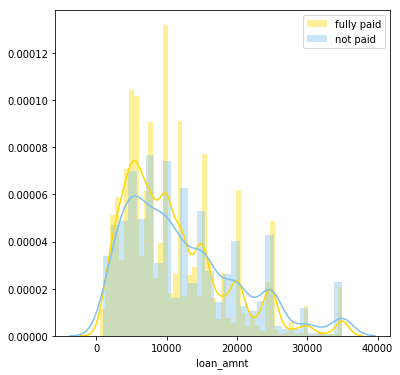

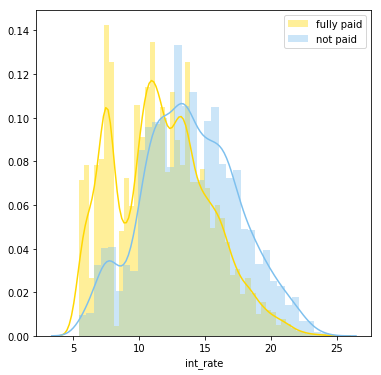

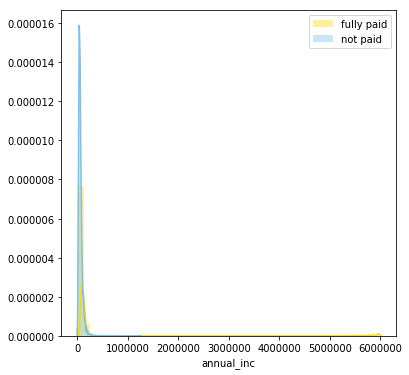

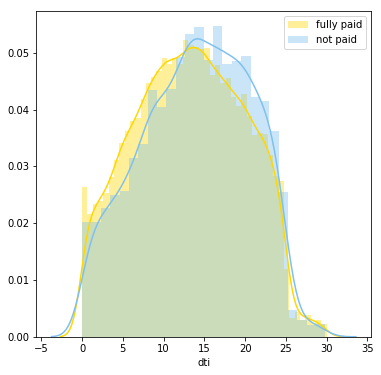

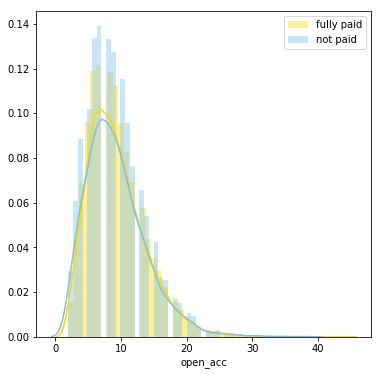

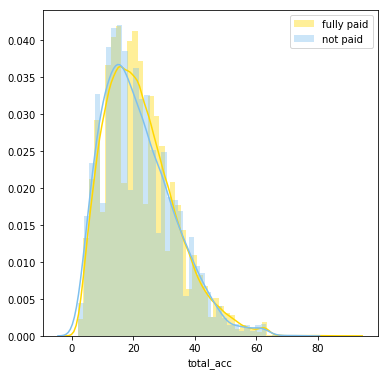

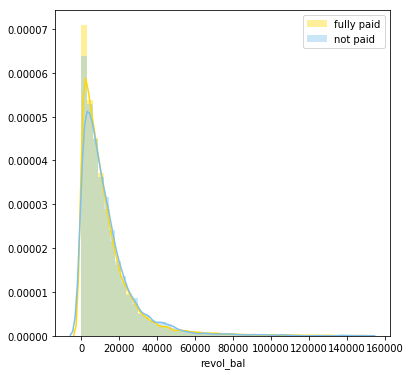

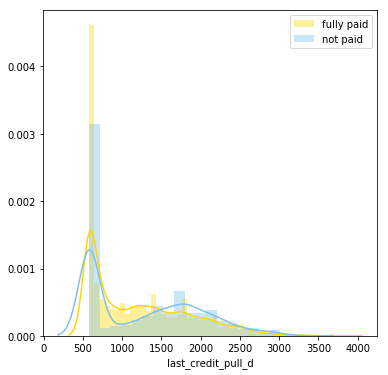

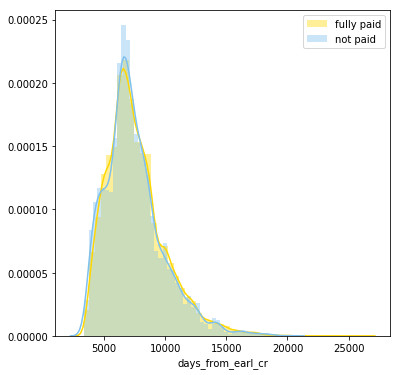

In [113]:
distribution('loan_amnt')
distribution('int_rate')
distribution('annual_inc')
distribution('dti')
distribution('open_acc')
distribution('total_acc')
distribution('revol_bal')
distribution('last_credit_pull_d')
distribution('days_from_earl_cr')


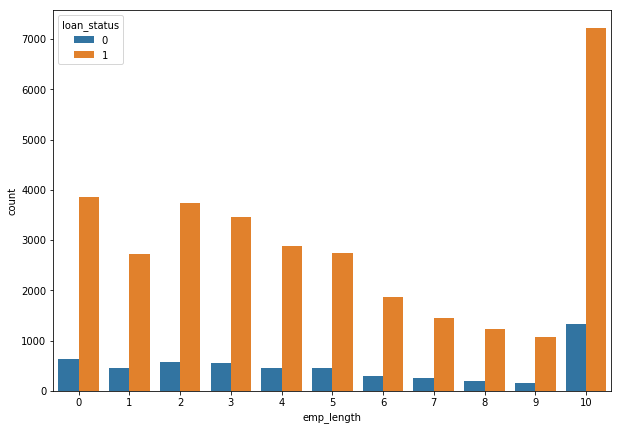

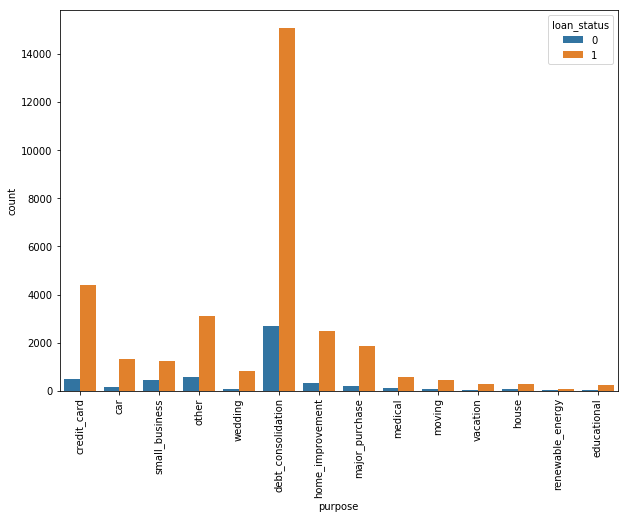

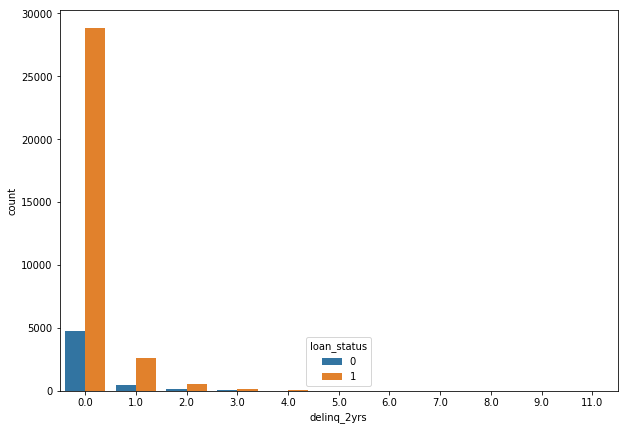

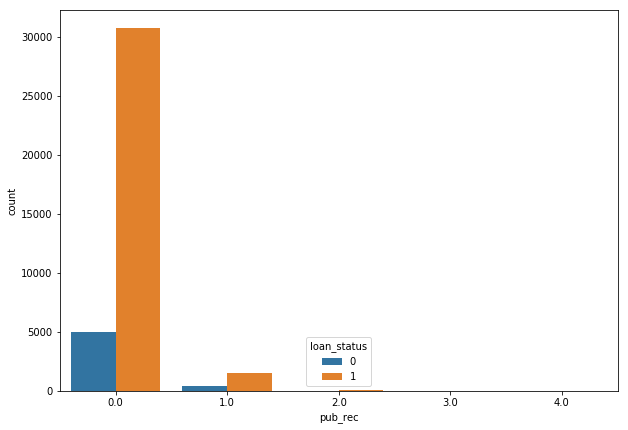

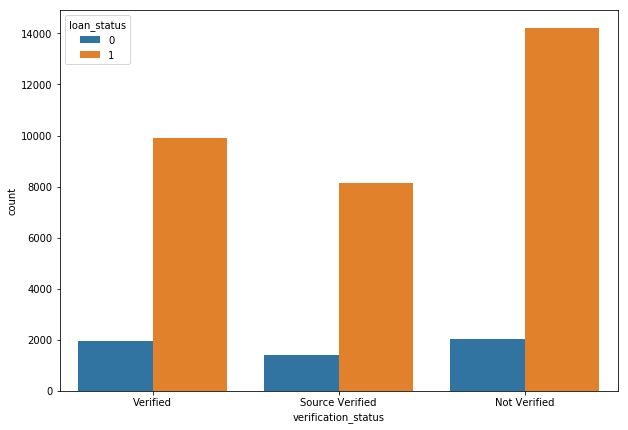

In [125]:
plt.figure(figsize=(10,7))
sns.countplot('emp_length', hue='loan_status', data=loans_2007)
plt.show()
plt.figure(figsize=(10,7))
sns.countplot('purpose', hue='loan_status', data=loans_2007)
plt.xticks(rotation='vertical')
plt.show()
plt.figure(figsize=(10,7))
sns.countplot('delinq_2yrs', hue='loan_status', data=loans_2007)
plt.show()
plt.figure(figsize=(10,7))
sns.countplot('pub_rec', hue='loan_status', data=loans_2007)
plt.show()
plt.figure(figsize=(10,7))
sns.countplot('verification_status', hue='loan_status', data=loans_2007)
plt.show()

## Predictive analytics

### Picking an error metric

We established that this is a binary classification problem in the very beginning, and we converted the loan_status column to 0s and 1s as a result. Before diving in and selecting an algorithm to apply to the data, we should select an error metric.

An error metric will help us figure out when our model is performing well, and when it's performing poorly. To tie error metrics all the way back to the original question we wanted to answer, let's say we're using a machine learning model to predict whether or not we should fund a loan on the Lending Club platform. Our objective in this is to make money -- we want to fund enough loans that are paid off on time to offset our losses from loans that aren't paid off. An error metric will help us determine if our algorithm will make us money or lose us money.

In this case, we're primarily concerned with false positives and false negatives. Both of these are different types of misclassifications. With a false positive, we predict that a loan will be paid off on time, but it actually isn't. This costs us money, since we fund loans that lose us money. With a false negative, we predict that a loan won't be paid off on time, but it actually would be paid off on time. This loses us potential money, since we didn't fund a loan that actually would have been paid off.

| Loan status actual | Prediction |     Error     |
|--------------------|------------|---------------|
|         0          |     0      | True negative |
|--------------------|------------|---------------|
|         1          |     0      | False negative|
|--------------------|------------|---------------|
|         0          |     1      | False positive|
|--------------------|------------|---------------|
|         1          |     1      | True positive |

In the loan_status and prediction columns, a 0 means that the loan wouldn't be paid off on time, and a 1 means that it would.
 As we are looking this from a conservative investor's point of view, we need to treat false positive and false negative differently. One would care more about loosing money than loosing an opportunity of additional return, in oder words, he would be more concerned about a flase positive

#### Class imbalance

In [62]:
loans_2007['loan_status'].value_counts()

1    32236
0     5383
Name: loan_status, dtype: int64

We see that there is a class imbalance in our target variable. There is about 6 times more 1s than 0s. An imbalance of this degree could cause problems when we measure our model using accuracy as a metric. For example, our model could predict all 1s and still show a high accuracy.

In this case, we don't want to use accuracy, and should instead use metrics that tell us the number of false positives and false negatives.

This means that we should optimize for:

1. high recall (true positive rate)
2. low fall-out (false positive rate)

In [130]:
loans = loans_2007.copy()

### Making dummy variables

In [131]:
loans.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status',
       'purpose', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'last_credit_pull_d',
       'days_from_earl_cr'],
      dtype='object')

In [132]:
dum = ['term','emp_length','home_ownership','verification_status','purpose','pub_rec']
pre = ['trm','eln','hown','ver','prpse','pbrc']
loans.drop('loan_status', axis=1, inplace=True)

for i, col in enumerate(dum):
    cat_col = pd.get_dummies(loans[col], prefix=pre[i])
    loans = pd.concat([loans, cat_col], axis=1)
    del loans[col]


### Dimensionality reduction

After creating dummy variables for categorical features, it looks like the dataframe has 53 features.
For reduction of features and better feature selection we'll do dimensionality reduction using Principal Component Analysis

In [135]:
#Scaling
from sklearn.preprocessing import StandardScaler
conv = StandardScaler()
scaled_data = conv.fit_transform(loans)

In [143]:
#PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = 35, svd_solver='full')
transformed_data = pca.fit_transform(scaled_data)

print(transformed_data.shape)
print(pca.explained_variance_ratio_*100)

(37619, 35)
[7.77882339 5.01680203 3.97750847 3.71239327 3.11274853 2.72807653
 2.6486773  2.47610433 2.36534557 2.27599013 2.15316795 2.14547265
 2.11844178 2.1045636  2.09013263 2.07267332 2.05013935 2.01675941
 2.00340033 1.98912123 1.98639373 1.97893767 1.95529705 1.95409047
 1.93885285 1.91615401 1.90870274 1.90069147 1.89613694 1.88213285
 1.88083457 1.87748765 1.86829799 1.84449828 1.84134711]


In [145]:
pca.explained_variance_ratio_.sum()*100

85.46619717890555

As can be seen in the outputs, 35 components from the PCA explains about 85% of the variance. Let's use all of these components to make a prediction and check for the false positive ratio
For now we will use a logistic regression model

In [160]:
transformed_df = pd.DataFrame(transformed_data)
train = transformed_df.iloc[:int(len(transformed_df)*0.7)]
train_target = loans_2007.iloc[:int(len(transformed_df)*0.7)]['loan_status']
test = transformed_df.iloc[int(len(transformed_df)*0.7):]
test_target = loans_2007.iloc[int(len(transformed_df)*0.7):]['loan_status']

from sklearn.linear_model import LogisticRegression
logit = LogisticRegression()
logit.fit(train, train_target)
predictions = logit.predict(test)

In [165]:
test_target = pd.DataFrame(test_target)

In [168]:
test_target['logit_pred'] = predictions

In [169]:
test_target.columns

Index(['loan_status', 'logit_pred'], dtype='object')

In [170]:
fp = len(test_target[(test_target['loan_status']==0) & (test_target['logit_pred']==1)])
tn = len(test_target[(test_target['loan_status']==0) & (test_target['logit_pred']==0)])
fpr = fp/(fp+tn)

In [171]:
fpr

0.9494109494109494

Clearly the false positive rate is way higher than any acceptable value
With this model we cannot predict a bad loan for an invvestor
This is because of the high class imbalance
Let's perform the above prediction one more time but this time we will set the 'class_weight' keyword of the logistic regression instance to 'balanced'

In [172]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(class_weight = 'balanced')
logit.fit(train, train_target)
predictions = logit.predict(test)

test_target = pd.DataFrame(test_target)
test_target['logit_pred'] = predictions
fp = len(test_target[(test_target['loan_status']==0) & (test_target['logit_pred']==1)])
tn = len(test_target[(test_target['loan_status']==0) & (test_target['logit_pred']==0)])
fpr = fp/(fp+tn)

fpr

0.5412335412335413

Setting the class weight keyword to balanced significantly reduced the false positive ratio to 54%.
However, from a conservative investor's point of view, we are still at about 50-50 odds of investing in a bad loan
Let's put a manual penalty for missclassifying a 0

In [178]:
penalty = {0:12, 1:1}

from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(class_weight = penalty)
logit.fit(train, train_target)
predictions = logit.predict(test)

test_target = pd.DataFrame(test_target)
test_target['logit_pred'] = predictions
fp = len(test_target[(test_target['loan_status']==0) & (test_target['logit_pred']==1)])
tn = len(test_target[(test_target['loan_status']==0) & (test_target['logit_pred']==0)])
tp = len(test_target[(test_target['loan_status']==1) & (test_target['logit_pred']==1)])
fn = len(test_target[(test_target['loan_status']==1) & (test_target['logit_pred']==0)])
fpr = fp/(fp+tn)
tpr = tp/(tp+fn)

print(fpr)
print(tpr)

0.1995841995841996
0.2845677130956009


It looks like assigning manual penalties lowered the false positive rate to 20%, and thus lowered our risk. Note that this comes at the expense of true positive rate. While we have fewer false positives, we're also missing opportunities to fund more loans and potentially make more money. Given that we're approaching this as a conservative investor, this strategy makes sense, but it's worth keeping in mind the tradeoffs.

Let's try a more complex algorithm, random forest. We learned about random forests in a previous mission, and constructed our own model. Random forests are able to work with nonlinear data, and learn complex conditionals. Logistic regressions are only able to work with linear data. Training a random forest algorithm may enable us to get more accuracy due to columns that correlate nonlinearly with loan_status.

We can use the RandomForestClassifer class from scikit-learn to do this.

### Random forrest

In [177]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(min_samples_leaf = 10, max_depth=20)

rfr.fit(train, train_target)
predictions = rfr.predict(test)

test_target = pd.DataFrame(test_target)
test_target['logit_pred'] = predictions
fp = len(test_target[(test_target['loan_status']==0) & (test_target['logit_pred']==1)])
tn = len(test_target[(test_target['loan_status']==0) & (test_target['logit_pred']==0)])
tp = len(test_target[(test_target['loan_status']==1) & (test_target['logit_pred']==1)])
fn = len(test_target[(test_target['loan_status']==1) & (test_target['logit_pred']==0)])
fpr = fp/(fp+tn)
tpr = tp/(tp+fn)

print(fpr)
print(tpr)

1.0
1.0


Unfortunately, using a random forrest regressor didn't give us a better false positive rate.The model is likely weighting too heavily on the 1 class, and still mostly predicting 1s.

Ultimately, 
our best model had a false positive rate of 20%, and a true positive rate of 28%. For a conservative investor, this means that they make money as long as the interest rate is high enough to offset the losses from 20% of borrowers defaulting, and that the pool of 28% of borrowers is large enough to make enough interest money to offset the losses.